In [2]:
# Install if needed
!pip install "dask[complete]" pyarrow s3fs --quiet

In [3]:
!pip install --upgrade "numexpr>=2.8.4" "s3fs>=2023.10.0"


In [18]:
import s3fs
import pyarrow.parquet as pq
import pandas as pd

fs = s3fs.S3FileSystem()
files = fs.glob('raw-data-714/processed/accidents_cleaned/*.parquet')
files = ['s3://' + f for f in files]

# Sample from all files (change n or frac as needed)
sampled = []
for f in files:
    table = pq.read_table(f, filesystem=fs)
    df = table.to_pandas()
    # Take a random 1% sample from each file
    sampled.append(df.sample(frac=0.01, random_state=42))

sample_df = pd.concat(sampled)
print(sample_df.head())


        Severity          Start_Time           Start_Lat            Start_Lng  \
68954          2 2016-11-03 09:58:13           34.029545  -118.21875800000001   
174964         3 2016-08-05 07:22:31           38.737278           -90.636459   
171063         2 2016-11-04 18:19:31            41.55304           -87.853874   
174796         2 2016-10-20 10:06:08           41.832355            -87.95536   
133779         3 2016-10-07 04:49:58  27.748459000000004           -82.677429   

       End_Lat End_Lng Distance(mi)              City Temperature(F)  \
68954     None    None         0.01       Los Angeles           75.9   
174964    None    None          0.0     Saint Charles           71.1   
171063    None    None         0.01       Orland Park           54.1   
174796    None    None         0.01         Oak Brook           55.0   
133779    None    None          0.0  Saint Petersburg           77.0   

       Humidity(%)  ... Junction No_Exit Railway Roundabout Station   Stop  \
68

In [33]:
import s3fs
import pyarrow.parquet as pq
import pandas as pd

# 1. List all parquet files in your S3 folder
fs = s3fs.S3FileSystem()
files = fs.glob('raw-data-714/processed/accidents_cleaned/*.parquet')
files = ['s3://' + f for f in files]

# 2. For each file, get min/max Start_Time
timeline_info = []

for i, f in enumerate(files):
    # Read just the Start_Time column
    table = pq.read_table(f, columns=['Start_Time'], filesystem=fs)
    df = table.to_pandas()
    # Convert to datetime, ignore parse errors just in case
    df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
    min_time = df['Start_Time'].min()
    max_time = df['Start_Time'].max()
    count = len(df)
    timeline_info.append({'file': f, 'min_time': min_time, 'max_time': max_time, 'rows': count})
    print(f"{i+1}/{len(files)}: {f.split('/')[-1]} | {min_time} --> {max_time} | Rows: {count}")

# 3. Optionally, save as DataFrame for easy viewing
timeline_df = pd.DataFrame(timeline_info)
timeline_df = timeline_df.sort_values('min_time')
timeline_df.to_csv('file_timeline_coverage.csv', index=False)
timeline_df


1/36: part-00000-bd491a7e-2e43-45c4-a92e-ba6baa9c8ed3-c000.snappy.parquet | 2016-02-08 05:46:00 --> 2017-01-26 20:07:03 | Rows: 227004
2/36: part-00001-bd491a7e-2e43-45c4-a92e-ba6baa9c8ed3-c000.snappy.parquet | 2016-03-19 09:54:00 --> 2017-06-13 17:24:37 | Rows: 228478
3/36: part-00002-bd491a7e-2e43-45c4-a92e-ba6baa9c8ed3-c000.snappy.parquet | 2017-06-01 04:14:49 --> 2022-09-08 17:56:22 | Rows: 225780
4/36: part-00003-bd491a7e-2e43-45c4-a92e-ba6baa9c8ed3-c000.snappy.parquet | 2021-08-29 13:48:13 --> 2022-03-02 23:30:53 | Rows: 224252
5/36: part-00004-bd491a7e-2e43-45c4-a92e-ba6baa9c8ed3-c000.snappy.parquet | 2021-02-16 05:24:54 --> 2021-09-01 20:18:11 | Rows: 224132
6/36: part-00005-bd491a7e-2e43-45c4-a92e-ba6baa9c8ed3-c000.snappy.parquet | 2020-09-05 19:29:22 --> 2021-02-25 22:38:52 | Rows: 224466
7/36: part-00006-bd491a7e-2e43-45c4-a92e-ba6baa9c8ed3-c000.snappy.parquet | 2019-12-26 17:09:52 --> 2020-10-30 23:53:55 | Rows: 225063
8/36: part-00007-bd491a7e-2e43-45c4-a92e-ba6baa9c8ed3-c

,file,min_time,max_time,rows
15,s3://raw-data-714/processed/accidents_cleaned/...,2016-01-14 20:18:33,2017-08-30 20:17:21,231457
0,s3://raw-data-714/processed/accidents_cleaned/...,2016-02-08 05:46:00,2017-01-26 20:07:03,227004
1,s3://raw-data-714/processed/accidents_cleaned/...,2016-03-19 09:54:00,2017-06-13 17:24:37,228478
22,s3://raw-data-714/processed/accidents_cleaned/...,2016-10-21 07:26:00,2023-02-23 23:46:30,198945
21,s3://raw-data-714/processed/accidents_cleaned/...,2016-10-21 07:26:00,2023-02-24 00:30:00,199125
35,s3://raw-data-714/processed/accidents_cleaned/...,2017-02-04 07:00:00,2019-08-31 00:43:43,215518
2,s3://raw-data-714/processed/accidents_cleaned/...,2017-06-01 04:14:49,2022-09-08 17:56:22,225780
16,s3://raw-data-714/processed/accidents_cleaned/...,2017-06-12 08:40:00,2023-03-31 23:30:00,200301
14,s3://raw-data-714/processed/accidents_cleaned/...,2017-07-26 12:16:21,2017-11-29 22:48:18,230232
32,s3://raw-data-714/processed/accidents_cleaned/...,2017-08-16 14:07:14,2021-01-01 08:17:51,221008


In [4]:
import s3fs
fs = s3fs.S3FileSystem()
files = fs.glob('raw-data-714/processed/accidents_cleaned/*.parquet')
files = ['s3://' + f for f in files]


In [5]:
print(f"Total files: {len(files)}")


Total files: 36


In [6]:
import math

total_files = len(files)
num_batches = 4
batch_size = math.ceil(total_files / num_batches)

batches = [files[i*batch_size:(i+1)*batch_size] for i in range(num_batches)]
for i, batch in enumerate(batches):
    print(f"Batch {i+1}: {len(batch)} files")


Batch 1: 9 files
Batch 2: 9 files
Batch 3: 9 files
Batch 4: 9 files


In [ ]:
import pyarrow.parquet as pq
import pandas as pd

all_batches = []

for idx, batch in enumerate(batches):
    print(f"\nLoading batch {idx+1} of {len(batches)} ({len(batch)} files)...")
    dfs = []
    for f in batch:
        table = pq.read_table(f, filesystem=fs)
        df = table.to_pandas()
        dfs.append(df)
    batch_df = pd.concat(dfs, ignore_index=True)
    print(f"Batch {idx+1} shape: {batch_df.shape}")
    # Optionally save or process batch here (aggregate, filter, export, etc.)
    all_batches.append(batch_df)
    del dfs  # Free memory



Loading batch 1 of 4 (9 files)...
Batch 1 shape: (2030377, 29)

Loading batch 2 of 4 (9 files)...
Batch 2 shape: (2002785, 29)

Loading batch 3 of 4 (9 files)...
Batch 3 shape: (1787826, 29)

Loading batch 4 of 4 (9 files)...


In [7]:
import pyarrow.parquet as pq
import pandas as pd
import s3fs

fs = s3fs.S3FileSystem()

summary_batches = []

for idx, batch in enumerate(batches):
    print(f"\nProcessing batch {idx+1} of {len(batches)} ({len(batch)} files)...")
    dfs = []
    for f in batch:
        table = pq.read_table(f, filesystem=fs)
        df = table.to_pandas()
        dfs.append(df)
    batch_df = pd.concat(dfs, ignore_index=True)
    batch_df['Start_Time'] = pd.to_datetime(batch_df['Start_Time'])
    # Aggregate: total accident count by date
    daily_counts = batch_df.groupby(batch_df['Start_Time'].dt.date).size().rename(f"batch{idx+1}")
    summary_batches.append(daily_counts)
    # Optionally: Save to CSV (optional)
    batch_df = None
    dfs = None
    import gc
    gc.collect()
    print(f"Done batch {idx+1}")

# Combine all batch summaries into a single Series/DataFrame
total_daily_counts = pd.concat(summary_batches, axis=1).sum(axis=1)
total_daily_counts = total_daily_counts.sort_index()
print(total_daily_counts.head())
total_daily_counts.to_csv('accidents_by_day.csv')



Processing batch 1 of 4 (9 files)...
Done batch 1

Processing batch 2 of 4 (9 files)...
Done batch 2

Processing batch 3 of 4 (9 files)...
Done batch 3

Processing batch 4 of 4 (9 files)...
Done batch 4
Start_Time
2016-01-14     7.0
2016-02-08    60.0
2016-02-09    59.0
2016-02-10    49.0
2016-02-11    93.0
dtype: float64


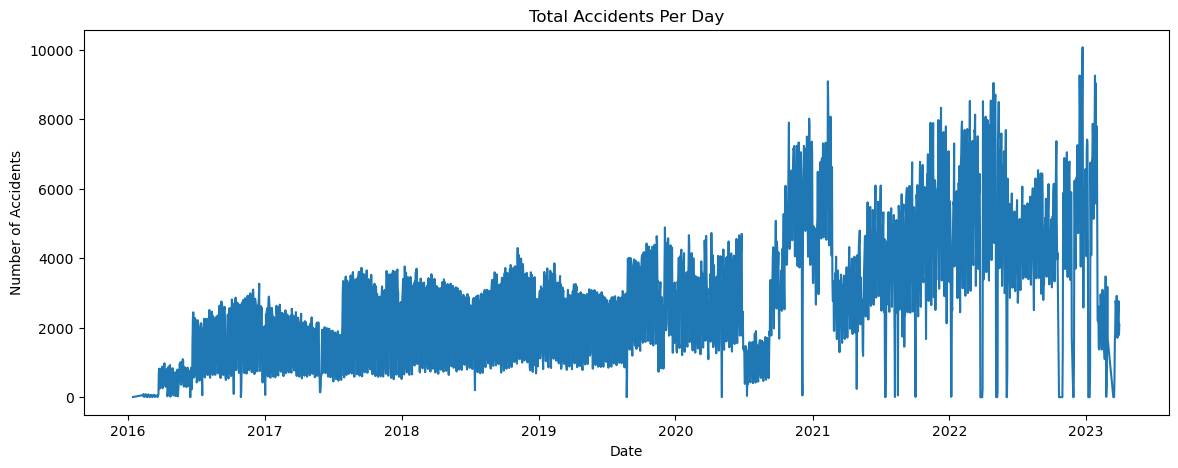

In [8]:
import matplotlib.pyplot as plt

total_daily_counts.plot(figsize=(14, 5))
plt.title("Total Accidents Per Day")
plt.xlabel("Date")
plt.ylabel("Number of Accidents")
plt.show()


In [9]:
print(type(total_daily_counts))
print(total_daily_counts.head())


<class 'pandas.core.series.Series'>
Start_Time
2016-01-14     7.0
2016-02-08    60.0
2016-02-09    59.0
2016-02-10    49.0
2016-02-11    93.0
dtype: float64


In [10]:
# In your batch processing loop:
batch_df['Start_Time'] = pd.to_datetime(batch_df['Start_Time'])
# Group by date and severity
sev_daily = batch_df.groupby([batch_df['Start_Time'].dt.date, batch_df['Severity']]).size().unstack(fill_value=0)
sev_daily.index = pd.to_datetime(sev_daily.index)


TypeError: 'NoneType' object is not subscriptable

In [12]:
import s3fs
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import math
import gc

# -- 1. List all parquet files from your S3 path --
fs = s3fs.S3FileSystem()
files = fs.glob('raw-data-714/processed/accidents_cleaned/*.parquet')
files = ['s3://' + f for f in files]
print(f"Total files found: {len(files)}")

# -- 2. Split files into 4 batches --
total_files = len(files)
num_batches = 4
batch_size = math.ceil(total_files / num_batches)
batches = [files[i*batch_size:(i+1)*batch_size] for i in range(num_batches)]
for i, batch in enumerate(batches):
    print(f"Batch {i+1}: {len(batch)} files")

# -- 3. For each batch, aggregate features by day --
all_daily_counts = []
all_sev_dailies = []
all_weather_dailies = []
all_weather_mode = []
all_signal_prop = []
all_city_daily = []

# Set top-N cities (for daily counts)
top_n_cities = 3
top_cities_overall = set()

# -- First pass: find top cities in ALL data (only first batch, for efficiency) --
dfs = []
for f in batches[0]:
    table = pq.read_table(f, filesystem=fs)
    df = table.to_pandas()
    dfs.append(df)
tmp_df = pd.concat(dfs, ignore_index=True)
if 'City' in tmp_df.columns:
    top_cities_overall = tmp_df['City'].value_counts().nlargest(top_n_cities).index.tolist()
print(f"Top {top_n_cities} cities (from first batch):", top_cities_overall)
del tmp_df, dfs; gc.collect()

for idx, batch in enumerate(batches):
    print(f"\nProcessing batch {idx+1}/{len(batches)} ({len(batch)} files)...")
    dfs = []
    for f in batch:
        table = pq.read_table(f, filesystem=fs)
        df = table.to_pandas()
        dfs.append(df)
    batch_df = pd.concat(dfs, ignore_index=True)
    print(f"Batch {idx+1} shape: {batch_df.shape}")

    # -- Datetime parse --
    batch_df['Start_Time'] = pd.to_datetime(batch_df['Start_Time'], errors='coerce')

    # -- Numeric conversion --
    batch_df['Temperature(F)'] = pd.to_numeric(batch_df['Temperature(F)'], errors='coerce')
    batch_df['Humidity(%)'] = pd.to_numeric(batch_df['Humidity(%)'], errors='coerce')

    # -- a) Total daily accident counts --
    daily_counts = batch_df.groupby(batch_df['Start_Time'].dt.date).size()
    all_daily_counts.append(daily_counts)

    # -- b) Daily counts by severity --
    sev_daily = batch_df.groupby([batch_df['Start_Time'].dt.date, batch_df['Severity']]).size().unstack(fill_value=0)
    all_sev_dailies.append(sev_daily)

    # -- c) Daily mean temperature and humidity --
    weather_daily = batch_df.groupby(batch_df['Start_Time'].dt.date)[['Temperature(F)', 'Humidity(%)']].mean()
    all_weather_dailies.append(weather_daily)

    # -- d) Most common weather condition per day --
    if 'Weather_Condition' in batch_df.columns:
        batch_df['Weather_Condition'] = batch_df['Weather_Condition'].fillna('Unknown')
        weather_mode = (
            batch_df.groupby(batch_df['Start_Time'].dt.date)['Weather_Condition']
            .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
        )
        all_weather_mode.append(weather_mode)

    # -- e) Proportion at traffic signals --
    if 'Traffic_Signal' in batch_df.columns:
        batch_df['Traffic_Signal'] = batch_df['Traffic_Signal'].map(
            {True: 1, False: 0, 'True': 1, 'False': 0}).fillna(0)
        traffic_signal_prop = batch_df.groupby(batch_df['Start_Time'].dt.date)['Traffic_Signal'].mean()
        all_signal_prop.append(traffic_signal_prop)

    # -- f) Daily counts for top N cities --
    if 'City' in batch_df.columns and top_cities_overall:
        city_daily = batch_df[batch_df['City'].isin(top_cities_overall)].groupby(
            [batch_df['Start_Time'].dt.date, 'City']).size().unstack(fill_value=0)
        all_city_daily.append(city_daily)

    # -- Memory management --
    batch_df = None
    dfs = None
    gc.collect()
    print(f"Done batch {idx+1}")

# -- 4. Combine all batch results --
# a) Total daily accident counts
total_daily_counts = pd.concat(all_daily_counts, axis=1).sum(axis=1)

# b) Severity-wise counts
total_sev_daily = pd.concat(all_sev_dailies, axis=0).groupby(level=0).sum()

# c) Daily weather averages
total_weather_daily = pd.concat(all_weather_dailies, axis=0).groupby(level=0).mean()

# d) Weather mode
if all_weather_mode:
    total_weather_mode = pd.concat(all_weather_mode, axis=0).groupby(level=0).agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
else:
    total_weather_mode = pd.Series(dtype="object")

# e) Traffic signal proportion
if all_signal_prop:
    total_signal_prop = pd.concat(all_signal_prop, axis=0).groupby(level=0).mean()
else:
    total_signal_prop = pd.Series(dtype="float64")

# f) Top city counts
if all_city_daily:
    total_city_daily = pd.concat(all_city_daily, axis=0).groupby(level=0).sum()
else:
    total_city_daily = pd.DataFrame()

# -- 5. Merge all features into a single DataFrame --
final_df = pd.DataFrame({
    'accident_count': total_daily_counts
})
final_df.index = pd.to_datetime(final_df.index)
final_df = final_df.sort_index()

# Add severity columns
for sev in total_sev_daily.columns:
    final_df[f'severity_{sev}'] = total_sev_daily[sev]

# Add weather columns
final_df = final_df.join(total_weather_daily, how='left')
final_df.rename(columns={
    'Temperature(F)': 'Temp_avg',
    'Humidity(%)': 'Humidity_avg'
}, inplace=True)

# Add weather_mode
final_df['weather_mode'] = final_df.index.map(total_weather_mode).astype('str') if not total_weather_mode.empty else np.nan

# Add traffic_signal_prop
final_df['traffic_signal_prop'] = final_df.index.map(total_signal_prop) if not total_signal_prop.empty else np.nan

# Add city counts for top N cities
if not total_city_daily.empty:
    for city in total_city_daily.columns:
        final_df[f'city_{str(city).replace(" ", "_")}'] = final_df.index.map(total_city_daily[city]).fillna(0).astype(int)

# -- Feature engineering: date-based and rolling features --
final_df['day_of_week'] = final_df.index.dayofweek
final_df['is_weekend'] = final_df['day_of_week'].isin([5,6]).astype(int)
final_df['month'] = final_df.index.month
final_df['year'] = final_df.index.year
final_df['accident_count_7d_avg'] = final_df['accident_count'].rolling(7, min_periods=1).mean()
final_df['accident_count_7d_std'] = final_df['accident_count'].rolling(7, min_periods=1).std()
final_df['accident_count_lag1'] = final_df['accident_count'].shift(1)

# -- Save final result --
final_df.to_csv('daily_accidents_with_features.csv')
print("\nSaved full daily aggregation with features to 'daily_accidents_with_features.csv'.")

# -- Show summary --
print("\nFinal DataFrame info:")
print(final_df.info())
print("\nDescriptive statistics:")
print(final_df.describe())
print("\nSample rows:")
print(final_df.head(10))


Total files found: 36
Batch 1: 9 files
Batch 2: 9 files
Batch 3: 9 files
Batch 4: 9 files
Top 3 cities (from first batch): ['Houston', 'Dallas', 'Los Angeles']

Processing batch 1/4 (9 files)...
Batch 1 shape: (2030377, 29)
Done batch 1

Processing batch 2/4 (9 files)...
Batch 2 shape: (2002785, 29)
Done batch 2

Processing batch 3/4 (9 files)...
Batch 3 shape: (1787826, 29)
Done batch 3

Processing batch 4/4 (9 files)...
Batch 4 shape: (1907406, 29)
Done batch 4

Saved full daily aggregation with features to 'daily_accidents_with_features.csv'.

Final DataFrame info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2572 entries, 2016-01-14 to 2023-03-31
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   accident_count         2572 non-null   float64
 1   severity_1             2572 non-null   float64
 2   severity_2             2572 non-null   int64  
 3   severity_3             2572 non-nul

In [13]:
print(final_df.shape)

(2572, 19)


In [16]:
import s3fs
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import math
import gc

# -- 1. List all parquet files from your S3 path --
fs = s3fs.S3FileSystem()
files = fs.glob('raw-data-714/processed/accidents_cleaned/*.parquet')
files = ['s3://' + f for f in files]
print(f"Total files found: {len(files)}")

# -- 2. Split files into 4 batches --
total_files = len(files)
num_batches = 4
batch_size = math.ceil(total_files / num_batches)
batches = [files[i*batch_size:(i+1)*batch_size] for i in range(num_batches)]
for i, batch in enumerate(batches):
    print(f"Batch {i+1}: {len(batch)} files")

# -- 3. For each batch, aggregate features by day --
all_daily_counts = []
all_sev_dailies = []
all_weather_dailies = []
all_weather_mode = []
all_signal_prop = []
all_city_daily = []

# Set top-N cities (for daily counts)
top_n_cities = 10
top_cities_overall = []

# -- First pass: find top 10 cities in ALL data (use first batch for speed) --
dfs = []
for f in batches[0]:
    table = pq.read_table(f, filesystem=fs)
    df = table.to_pandas()
    dfs.append(df)
tmp_df = pd.concat(dfs, ignore_index=True)
if 'City' in tmp_df.columns:
    top_cities_overall = tmp_df['City'].value_counts().nlargest(top_n_cities).index.tolist()
print(f"Top {top_n_cities} cities (from first batch):", top_cities_overall)
del tmp_df, dfs; gc.collect()

for idx, batch in enumerate(batches):
    print(f"\nProcessing batch {idx+1}/{len(batches)} ({len(batch)} files)...")
    dfs = []
    for f in batch:
        table = pq.read_table(f, filesystem=fs)
        df = table.to_pandas()
        dfs.append(df)
    batch_df = pd.concat(dfs, ignore_index=True)
    print(f"Batch {idx+1} shape: {batch_df.shape}")

    # -- Datetime parse --
    batch_df['Start_Time'] = pd.to_datetime(batch_df['Start_Time'], errors='coerce')

    # -- Numeric conversion --
    batch_df['Temperature(F)'] = pd.to_numeric(batch_df['Temperature(F)'], errors='coerce')
    batch_df['Humidity(%)'] = pd.to_numeric(batch_df['Humidity(%)'], errors='coerce')

    # -- a) Total daily accident counts --
    daily_counts = batch_df.groupby(batch_df['Start_Time'].dt.date).size()
    all_daily_counts.append(daily_counts)

    # -- b) Daily counts by severity --
    sev_daily = batch_df.groupby([batch_df['Start_Time'].dt.date, batch_df['Severity']]).size().unstack(fill_value=0)
    all_sev_dailies.append(sev_daily)

    # -- c) Daily mean temperature and humidity --
    weather_daily = batch_df.groupby(batch_df['Start_Time'].dt.date)[['Temperature(F)', 'Humidity(%)']].mean()
    all_weather_dailies.append(weather_daily)

    # -- d) Most common weather condition per day --
    if 'Weather_Condition' in batch_df.columns:
        batch_df['Weather_Condition'] = batch_df['Weather_Condition'].fillna('Unknown')
        weather_mode = (
            batch_df.groupby(batch_df['Start_Time'].dt.date)['Weather_Condition']
            .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
        )
        all_weather_mode.append(weather_mode)

    # -- e) Proportion at traffic signals --
    if 'Traffic_Signal' in batch_df.columns:
        batch_df['Traffic_Signal'] = batch_df['Traffic_Signal'].map(
            {True: 1, False: 0, 'True': 1, 'False': 0}).fillna(0)
        traffic_signal_prop = batch_df.groupby(batch_df['Start_Time'].dt.date)['Traffic_Signal'].mean()
        all_signal_prop.append(traffic_signal_prop)

    # -- f) Daily counts for top 10 cities --
    if 'City' in batch_df.columns and top_cities_overall:
        city_daily = batch_df[batch_df['City'].isin(top_cities_overall)].groupby(
            [batch_df['Start_Time'].dt.date, 'City']).size().unstack(fill_value=0)
        all_city_daily.append(city_daily)

    # -- Memory management --
    batch_df = None
    dfs = None
    gc.collect()
    print(f"Done batch {idx+1}")

# -- 4. Combine all batch results --
# a) Total daily accident counts
total_daily_counts = pd.concat(all_daily_counts, axis=1).sum(axis=1)

# b) Severity-wise counts
total_sev_daily = pd.concat(all_sev_dailies, axis=0).groupby(level=0).sum()

# c) Daily weather averages
total_weather_daily = pd.concat(all_weather_dailies, axis=0).groupby(level=0).mean()

# d) Weather mode
if all_weather_mode:
    total_weather_mode = pd.concat(all_weather_mode, axis=0).groupby(level=0).agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
else:
    total_weather_mode = pd.Series(dtype="object")

# e) Traffic signal proportion
if all_signal_prop:
    total_signal_prop = pd.concat(all_signal_prop, axis=0).groupby(level=0).mean()
else:
    total_signal_prop = pd.Series(dtype="float64")

# f) Top city counts
if all_city_daily:
    total_city_daily = pd.concat(all_city_daily, axis=0).groupby(level=0).sum()
else:
    total_city_daily = pd.DataFrame()

# -- 5. Merge all features into a single DataFrame --
final_df = pd.DataFrame({
    'accident_count': total_daily_counts
})
final_df.index = pd.to_datetime(final_df.index)
final_df = final_df.sort_index()

# Add severity columns
for sev in total_sev_daily.columns:
    final_df[f'severity_{sev}'] = total_sev_daily[sev]

# Add weather columns
final_df = final_df.join(total_weather_daily, how='left')
final_df.rename(columns={
    'Temperature(F)': 'Temp_avg',
    'Humidity(%)': 'Humidity_avg'
}, inplace=True)

# Add weather_mode
final_df['weather_mode'] = final_df.index.map(total_weather_mode).astype('str') if not total_weather_mode.empty else np.nan

# Add traffic_signal_prop
final_df['traffic_signal_prop'] = final_df.index.map(total_signal_prop) if not total_signal_prop.empty else np.nan

# Add city counts for top 10 cities
if not total_city_daily.empty:
    for city in total_city_daily.columns:
        final_df[f'city_{str(city).replace(" ", "_")}'] = final_df.index.map(total_city_daily[city]).fillna(0).astype(int)

# -- Feature engineering: date-based and rolling features --
final_df['day_of_week'] = final_df.index.dayofweek
final_df['is_weekend'] = final_df['day_of_week'].isin([5,6]).astype(int)
final_df['month'] = final_df.index.month
final_df['year'] = final_df.index.year
final_df['accident_count_7d_avg'] = final_df['accident_count'].rolling(7, min_periods=1).mean()
final_df['accident_count_7d_std'] = final_df['accident_count'].rolling(7, min_periods=1).std()
final_df['accident_count_lag1'] = final_df['accident_count'].shift(1)

# -- Save final result --
final_df.to_csv('daily_accidents_with_features.csv')
print("\nSaved full daily aggregation with features to 'daily_accidents_with_features.csv'.")

# -- Show summary --
print("\nFinal DataFrame info:")
print(final_df.info())
print("\nDescriptive statistics:")
print(final_df.describe())
print("\nSample rows:")
print(final_df.head(10))


Total files found: 36
Batch 1: 9 files
Batch 2: 9 files
Batch 3: 9 files
Batch 4: 9 files
Top 10 cities (from first batch): ['Houston', 'Dallas', 'Los Angeles', 'Charlotte', 'Austin', 'Atlanta', 'Miami', 'Raleigh', 'Nashville', 'Baton Rouge']

Processing batch 1/4 (9 files)...
Batch 1 shape: (2030377, 29)
Done batch 1

Processing batch 2/4 (9 files)...
Batch 2 shape: (2002785, 29)
Done batch 2

Processing batch 3/4 (9 files)...
Batch 3 shape: (1787826, 29)
Done batch 3

Processing batch 4/4 (9 files)...
Batch 4 shape: (1907406, 29)
Done batch 4

Saved full daily aggregation with features to 'daily_accidents_with_features.csv'.

Final DataFrame info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2572 entries, 2016-01-14 to 2023-03-31
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   accident_count         2572 non-null   float64
 1   severity_1             2572 non-null   float64
 2   seve